# Stroke Prediction Dataset

## Initialization

In [1]:
# General Libraries
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import warnings


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

# Data Preparation / Preprocessing
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Data Sampling
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid

# Shapley Additive Explanations (SHAP)
import shap

# Extra
import joblib
import pickle

warnings.filterwarnings('ignore')

C:\Users\Rain\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [43]:
# Data Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [44]:
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


None

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Preprocessing

In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


#### Check Duplicate IDs

In [5]:
df.duplicated('id').sum()

0

#### Drop ID since it's an identifier

In [6]:
df_cleaned = df.copy(deep=True)
df_cleaned.drop('id', axis=1, inplace=True)

#### `hypertension` and `heart_disease` will be converted to categorical later as these are currently integers**

In [7]:
categorical_mapping = {
    0: 'no',
    1: 'yes'
}

df_cleaned['hypertension'] = df_cleaned['hypertension'].map(categorical_mapping)
df_cleaned['heart_disease'] = df_cleaned['heart_disease'].map(categorical_mapping)

#### Check unique values of the categorical columns

**Column and column value formatting**

In [8]:
df_cleaned.columns = df_cleaned.columns.str.lower()

categorical = df_cleaned.columns[df_cleaned.dtypes=='object'].tolist()

for c in categorical:
    df_cleaned[c] = df_cleaned[c].str.lower()
    df_cleaned[c] = df_cleaned[c].str.replace(' ' , '_')
    df_cleaned[c] = df_cleaned[c].str.replace('-', '_')

In [9]:
for c in categorical:
    print('\n######')
    print(c)
    print('count of unique values: ', df_cleaned[c].nunique())
    print('unique values: ', df_cleaned[c].unique()[:10])
    print('\n', df_cleaned.value_counts(c))


######
gender
count of unique values:  3
unique values:  ['male' 'female' 'other']

 gender
female    2994
male      2115
other        1
dtype: int64

######
hypertension
count of unique values:  2
unique values:  ['no' 'yes']

 hypertension
no     4612
yes     498
dtype: int64

######
heart_disease
count of unique values:  2
unique values:  ['yes' 'no']

 heart_disease
no     4834
yes     276
dtype: int64

######
ever_married
count of unique values:  2
unique values:  ['yes' 'no']

 ever_married
yes    3353
no     1757
dtype: int64

######
work_type
count of unique values:  5
unique values:  ['private' 'self_employed' 'govt_job' 'children' 'never_worked']

 work_type
private          2925
self_employed     819
children          687
govt_job          657
never_worked       22
dtype: int64

######
residence_type
count of unique values:  2
unique values:  ['urban' 'rural']

 residence_type
urban    2596
rural    2514
dtype: int64

######
smoking_status
count of unique values:  4
unique 

#### Check distribution of target variable

In [10]:
stroke_count = df_cleaned.value_counts('stroke').reset_index()
stroke_count = stroke_count.rename(columns={'stroke':'stroke', 0:'count'})
stroke_count['percentage'] = round(stroke_count['count']/stroke_count['count'].sum()*100,2)
stroke_count

,stroke,count,percentage
0,0,4861,95.13
1,1,249,4.87


In [11]:
print("%.2f%% of individuals do not have stroke history" % stroke_count['percentage'][0])
print("%.2f%% of individuals have stroke history" % stroke_count['percentage'][1])

95.13% of individuals do not have stroke history
4.87% of individuals have stroke history


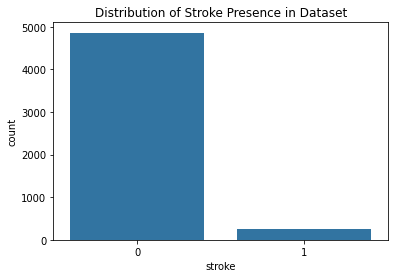

In [12]:
sns.barplot(data=stroke_count, x='stroke', y='count')
plt.title('Distribution of Stroke Presence in Dataset')
plt.show()

#### Proportion Chance Criterion

Given the imbalanced dataset, the proportion chance criterion will be used as a baseline for model evaluation. PCC will be the ratio of positive stroke examples over the total count of the dataset.

In [13]:
# Proportion Chance Criterion
pcc = stroke_count['percentage'][1]
pcc_allowance = pcc*1.25

print(f'Proportion Chance Criterion: %.2f%%' % pcc)
print(f'Proportion Chance Criterion with Allowance: %.2f%%' % pcc_allowance)

Proportion Chance Criterion: 4.87%
Proportion Chance Criterion with Allowance: 6.09%


#### Other Gender will be dropped

In [14]:
df_cleaned.value_counts('gender')

gender
female    2994
male      2115
other        1
dtype: int64

In [15]:
df_cleaned = df_cleaned[df_cleaned['gender']!='other']

#### Check Null Values

In [16]:
df_cleaned.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [17]:
missing_bmi = df_cleaned[df_cleaned.bmi.isnull()].value_counts('stroke').reset_index()
missing_bmi.columns=['stroke', 'count_of_missing_bmi']

total_counts = df_cleaned.value_counts('stroke').reset_index()
total_counts.columns=['stroke', 'count_of_total']

total_counts = missing_bmi.merge(total_counts, on='stroke')
total_counts['percentage'] = round((total_counts['count_of_missing_bmi']/total_counts['count_of_total'])*100, 2)
total_counts

,stroke,count_of_missing_bmi,count_of_total,percentage
0,0,161,4860,3.31
1,1,40,249,16.06


**Looking at datapoints with null bmi values, 40 individuals have stroke history. Given the highly imbalanced nature of the dataset, the missing bmi values with the median given the right skewed distribution of BMI as shown below**

In [18]:
df_cleaned['bmi'] = df_cleaned['bmi'].fillna(df_cleaned['bmi'].median())

#### Visualization of Numerical Variables

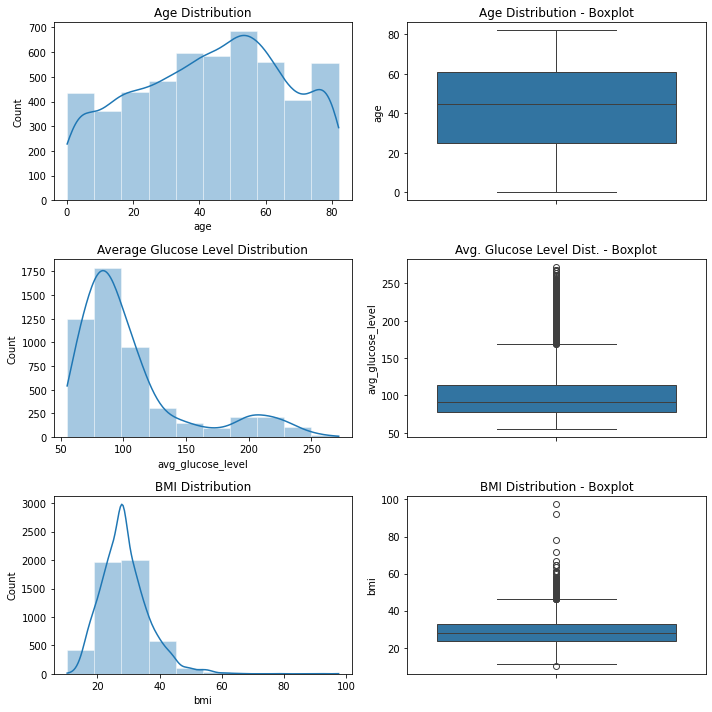

In [19]:
fig = plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
sns.histplot(df_cleaned['age'], bins=10, kde=True, alpha=0.4, edgecolor=(1,1,1,.4))
plt.title('Age Distribution')

plt.subplot(3,2,2)
sns.boxplot(df_cleaned['age'])
plt.title('Age Distribution - Boxplot')

plt.subplot(3,2,3)
sns.histplot(df_cleaned['avg_glucose_level'], bins=10, kde=True, alpha=0.4, edgecolor=(1,1,1,.4))
plt.title('Average Glucose Level Distribution')

plt.subplot(3,2,4)
sns.boxplot(df_cleaned['avg_glucose_level'])
plt.title('Avg. Glucose Level Dist. - Boxplot')

plt.subplot(3,2,5)
sns.histplot(df_cleaned['bmi'], bins=10, kde=True, alpha=0.4, edgecolor=(1,1,1,.4))
plt.title('BMI Distribution')

plt.subplot(3,2,6)
sns.boxplot(df_cleaned['bmi'])
plt.title('BMI Distribution - Boxplot')

plt.tight_layout()
plt.show()

Average glucose level and BMI have right skewed distributions, with outliers. Outliers will be handled via Winsorization.

#### Outlier Handling

#### Winsorizer

In [20]:
df_outliers = df_cleaned.copy()
df_outliers_num = df_outliers[['avg_glucose_level', 'bmi']]

In [21]:
# initialize winsorizer
win = Winsorizer(tail='both', fold=2)

# fit to glucose level and bmi and save as df
winsorized = win.fit_transform(df_outliers_num)
winsorized.columns=['avg_glucose_level', 'bmi']

# drop original data and replace with winsorized
df_win = df_outliers.drop(['avg_glucose_level', 'bmi'], axis=1)
df_win = pd.concat((df_win, winsorized), axis=1)

#### LocalOutlierFactor

Count of Dropped Outliers : 196


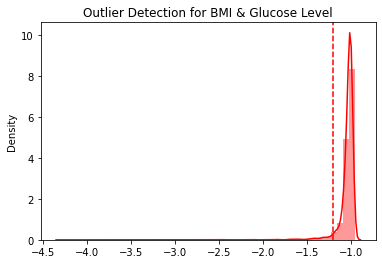

In [22]:
# initialize LOF
lof = LocalOutlierFactor()

# fit to glucose level and bmi
y_pred_lof = lof.fit_predict(df_outliers_num)
lof_scores = lof.negative_outlier_factor_

# transfrm y_pred_lof to -1 and 1 values based on threshold
threshold = -1.2
y_pred_lof = (lof_scores > threshold) * 2 - 1

# create df with lof scores
df_lof = df_outliers.copy()
df_lof['lof_score'] = y_pred_lof
df_lof_clean = df_lof[df_lof['lof_score']==1]

# tally dropped datapoints
dropped = Counter(df_lof['lof_score'])[-1]
print('Count of Dropped Outliers :', dropped)

sns.distplot(lof_scores, color='r')
plt.axvline(threshold, linestyle='--', color='r')
plt.title('Outlier Detection for BMI & Glucose Level')
plt.show()

#### Histplot Comparison

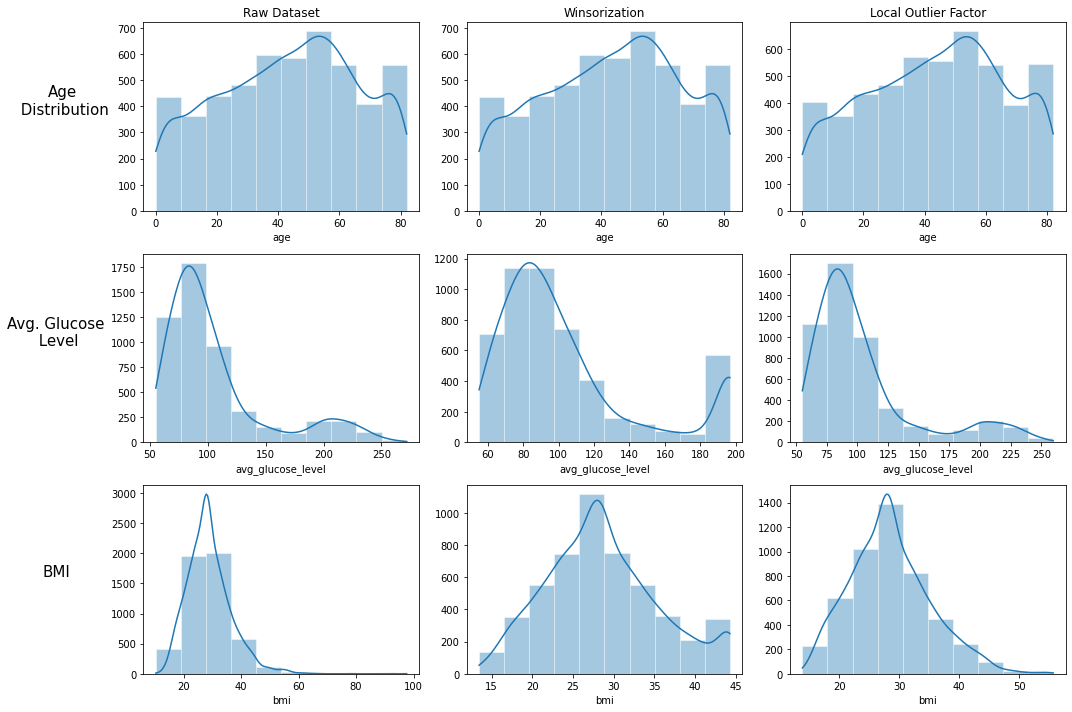

In [23]:
# define dataframes and features to be plotted
dfs = [df_cleaned, df_win, df_lof_clean]
features = ['age', 'avg_glucose_level', 'bmi']

# plot histograms of selected dfs and features
fig3 = plt.figure(figsize=(15,10))
idx = 1

for feature in features:
    for data  in dfs:
        plt.subplot(3,3,idx)
        sns.histplot(data[feature], bins=10, kde=True, alpha=0.4, edgecolor=(1,1,1,.4))
        plt.ylabel('')
        idx +=1

# formatting
plt.subplot(3,3,1)
plt.title('Raw Dataset')
plt.ylabel('Age\n Distribution', rotation=0, fontsize=15, labelpad=55)

plt.subplot(3,3,2)
plt.title('Winsorization')

plt.subplot(3,3,3)
plt.title('Local Outlier Factor')

plt.subplot(3,3,4)
plt.ylabel('Avg. Glucose\n Level', rotation=0, fontsize=15, labelpad=55)

plt.subplot(3,3,7)
plt.ylabel('BMI', rotation=0, fontsize=15, labelpad=55)

plt.tight_layout()
plt.show()

#### Boxplot Comparison

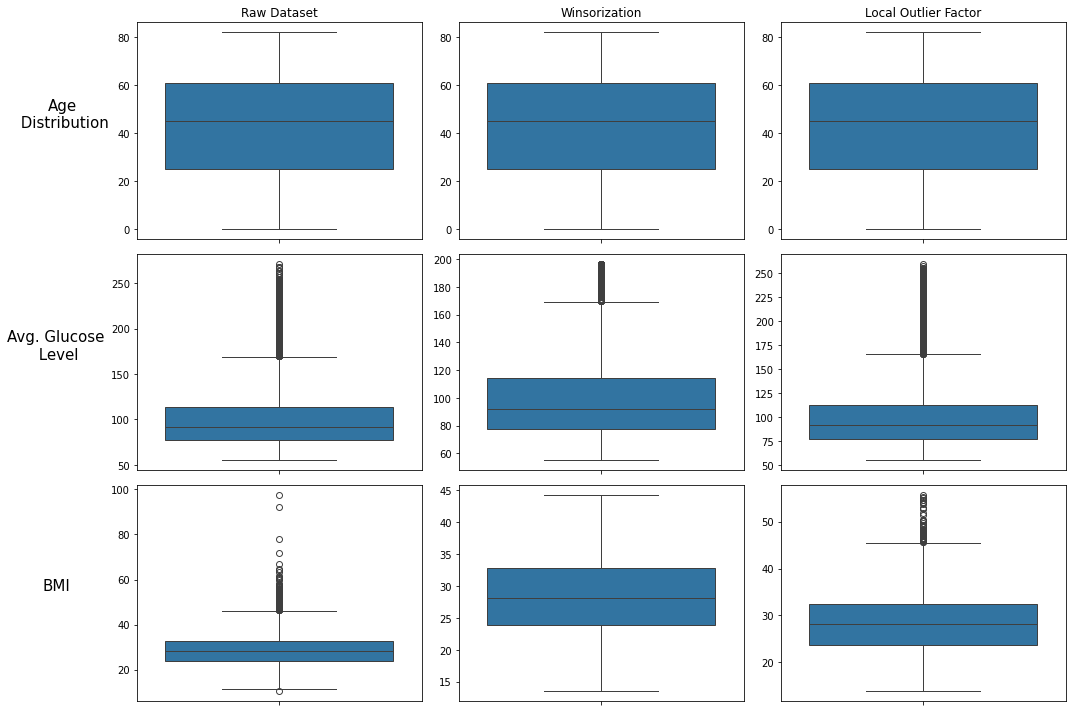

In [24]:
# define dataframes and features to be plotted
dfs = [df_cleaned, df_win, df_lof_clean]
features = ['age', 'avg_glucose_level', 'bmi']

# plot histograms of selected dfs and features
fig3 = plt.figure(figsize=(15,10))
idx = 1

for feature in features:
    for data  in dfs:
        plt.subplot(3,3,idx)
        sns.boxplot(data[feature])
        plt.ylabel('')
        idx +=1

# formatting
plt.subplot(3,3,1)
plt.title('Raw Dataset')
plt.ylabel('Age\n Distribution', rotation=0, fontsize=15, labelpad=55)

plt.subplot(3,3,2)
plt.title('Winsorization')

plt.subplot(3,3,3)
plt.title('Local Outlier Factor')

plt.subplot(3,3,4)
plt.ylabel('Avg. Glucose\n Level', rotation=0, fontsize=15, labelpad=55)

plt.subplot(3,3,7)
plt.ylabel('BMI', rotation=0, fontsize=15, labelpad=55)

plt.tight_layout()
plt.show()

Winsorized data will be used as it more effectively reduced the effect of outliers vs LOF. Outlier handling methods had no remarkable effect on age. Winsorizer notably reduced outliers on avg. glucose level and BMI and limited the max values to 200 and 45 respectively. LOF had a lesser effect on outlier reduction. 

#### Apply Log Transformation due to skewedness

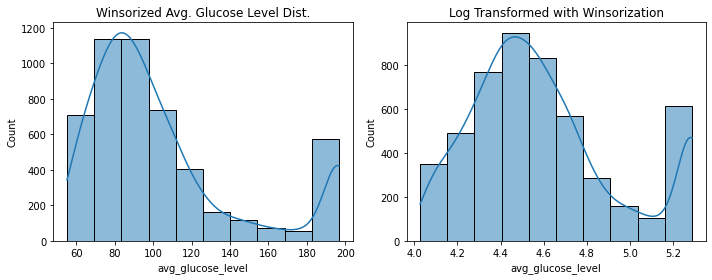

In [25]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot((df_win['avg_glucose_level']), bins=10, kde=True)
plt.title('Winsorized Avg. Glucose Level Dist.')

plt.subplot(1,2,2)
sns.histplot(np.log1p(df_win['avg_glucose_level']), bins=10, kde=True)
plt.title('Log Transformed with Winsorization')

plt.tight_layout()
plt.show()

In [26]:
df_final = df_win.copy(deep=True)
df_final['avg_glucose_level_log'] = np.log1p(df_final['avg_glucose_level'])
df_final.drop('avg_glucose_level', axis=1, inplace=True)
df_final.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke,bmi,avg_glucose_level_log
0,male,67.0,no,yes,yes,private,urban,formerly_smoked,1,36.6,5.286759
1,female,61.0,no,no,yes,self_employed,rural,never_smoked,1,28.1,5.286759
2,male,80.0,no,yes,yes,private,rural,never_smoked,1,32.5,4.672081
3,female,49.0,no,no,yes,private,urban,smokes,1,34.4,5.148831
4,female,79.0,yes,no,yes,self_employed,rural,never_smoked,1,24.0,5.165471


## Machine Learning Pipeline

Outline: 

1. Convert dataset to one hot encoded features.
2. Set up train val holdout split, ensure data is stratified for the split
3. Set up machine learning pipeline, ensuring the ff:
    * cross validation
    * standardization of numerical features
    * test sampling techniques
    * track runtime, train and val f1 scores.
    * explore roc auc curves
4. Hypertune selected models via gridsearch and select best based on f1 score

### One Hot Encoding

In [27]:
# initialize and fit the dataset into dictvectorizer
dv = DictVectorizer(sparse=False)
one_hot = dv.fit_transform(df_final.to_dict(orient='records'))

# convert to dataframe
df_one_hot = pd.DataFrame(one_hot, columns=dv.feature_names_)
df_one_hot.head()

,age,avg_glucose_level_log,bmi,ever_married=no,ever_married=yes,gender=female,gender=male,heart_disease=no,heart_disease=yes,hypertension=no,...,smoking_status=formerly_smoked,smoking_status=never_smoked,smoking_status=smokes,smoking_status=unknown,stroke,work_type=children,work_type=govt_job,work_type=never_worked,work_type=private,work_type=self_employed
0,67.0,5.286759,36.6,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,61.0,5.286759,28.1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,80.0,4.672081,32.5,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,49.0,5.148831,34.4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,79.0,5.165471,24.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Apply Scaler

In [28]:
minmax = MinMaxScaler()

df_scaled = pd.DataFrame(minmax.fit_transform(df_one_hot), columns= dv.feature_names_)
df_scaled.head()

,age,avg_glucose_level_log,bmi,ever_married=no,ever_married=yes,gender=female,gender=male,heart_disease=no,heart_disease=yes,hypertension=no,...,smoking_status=formerly_smoked,smoking_status=never_smoked,smoking_status=smokes,smoking_status=unknown,stroke,work_type=children,work_type=govt_job,work_type=never_worked,work_type=private,work_type=self_employed
0,0.816895,1.000000,0.751223,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.743652,1.000000,0.475214,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.975586,0.511876,0.618090,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.597168,0.890470,0.679786,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.963379,0.903684,0.342081,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Train-Validation-Holdout Split

In [29]:
X = df_scaled.drop(['stroke'], axis=1)
y = df_scaled['stroke']

X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X, y, random_state=1, test_size=0.25, stratify=y)

### Auto Machine Learning Function

In [30]:
""" 
 Define a function that evalutes models based on the parameters given
 X = features
 y = target
 model_dict = dictionary; contains the machine learning models to be used
 cv = cross-validation method
 resampling = resampling technique to be used

"""

def auto_ml(X, y, model_dict, scaler=None, cv=None, resampling=None):
    
    results = {}
    results_plot = {}
    
    for model_name, model in tqdm(model_dict.items()):
        
        train_accuracy = []
        val_accuracy = []
        
        train_precision = []
        val_precision = []
        
        train_recall = []
        val_recall = []
        
        train_f1 = []
        val_f1 = []
        
        runtime = []
        
        # apply cross validation split 
        for train_index, val_index in tqdm(cv.split(X, y)):
            
            X_train, X_val = np.array(X.iloc[train_index]), np.array(X.iloc[val_index])
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass
            
            # Apply resampling technique
            if resampling is not None:
                X_train, y_train = resampling.fit_resample(X_train, y_train)
            else:
                pass
            
        # record the start time for model fitting 
        start_time = time.time()
        
        # fit model
        model.fit(X_train, y_train)
        
        # predict targets
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        # record end time
        end_time = time.time()
        
        ## Evaluation Metrics
        
        # Accuracy
        train_accuracy.append(model.score(X_train, y_train))
        val_accuracy.append(model.score(X_val, y_val))
        
        # Precision
        train_precision.append(precision_score(y_train, train_preds))
        val_precision.append(precision_score(y_val, val_preds))
        
        # Recall
        train_recall.append(recall_score(y_train, train_preds))
        val_recall.append(recall_score(y_val, val_preds))
        
        # F1-Score
        train_f1.append(f1_score(y_train, train_preds))
        val_f1.append(f1_score(y_val, val_preds))
        
        # Runtime
        runtime.append(end_time-start_time)
        
        # Save results to dictionary
        
        results[model_name] = {
            'Train Accuracy': np.round(np.mean(train_accuracy) * 100, 2),
            'Val Accuracy': np.round(np.mean(val_accuracy) * 100, 2),
            'Train Precision': np.round(np.mean(train_precision) * 100, 2), 
            'Val Precision': np.round(np.mean(val_precision) * 100, 2),
            'Train Recall': np.round(np.mean(train_recall) * 100, 2),
            'Val Recall': np.round(np.mean(val_recall) * 100, 2),
            'Train F1-Score': np.round(np.mean(train_f1) * 100, 2),
            'Val F1-Score': np.round(np.mean(val_f1) * 100, 2),
            'Runtime': np.round(np.sum(runtime), 2)
        }
        
        results_plot[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_accuracy)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_accuracy)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train F1-Score': '{:.2f}%'.format(np.round(np.mean(train_f1)*100, 2)),
                'Val F1-Score': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Runtime (s)': '{:.2f}'.format(np.round(np.sum(runtime), 2))
            }
        
    results = pd.DataFrame(results).transpose()
    results_plot = pd.DataFrame(results_plot).transpose()
    return [results, results_plot]

### Machine Learning Model Dictionary

In [32]:
models_dict = {
    'LogisticRegression': LogisticRegression(random_state=1),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=1), 
    'RandomForestClassifier': RandomForestClassifier(random_state=1), 
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=1), 
    'AdaBoostClassifier': AdaBoostClassifier(random_state=1),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=1),
    'XGBClassifier': XGBClassifier(random_state=1)
}


In [33]:
base_models = auto_ml(X_trainval, y_trainval, models_dict,
                      cv=StratifiedKFold(n_splits=5))
base_models[1]

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
LogisticRegression,95.14%,95.04%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.04s
DecisionTreeClassifier,100.00%,89.30%,100.00%,12.07%,100.00%,18.42%,100.00%,14.58%,0.01s
RandomForestClassifier,99.97%,94.78%,100.00%,0.00%,99.33%,0.00%,99.66%,0.00%,0.34s
GradientBoostingClassifier,96.05%,94.39%,86.84%,14.29%,22.15%,2.63%,35.29%,4.44%,0.46s
AdaBoostClassifier,95.14%,94.78%,50.00%,0.00%,4.70%,0.00%,8.59%,0.00%,0.19s
ExtraTreesClassifier,100.00%,93.86%,100.00%,20.00%,100.00%,7.89%,100.00%,11.32%,0.27s
XGBClassifier,99.97%,92.82%,100.00%,16.00%,99.33%,10.53%,99.66%,12.70%,1.43s


### Apply Resampling Techniques

In [34]:
resampling_tech = {
    'SMOTE': SMOTE(random_state=1), 
    'ADASYN': ADASYN(random_state=1),
    'TomekLinks': TomekLinks()
}


In [35]:
resampling_summary = []
for resampling_name, resampling in resampling_tech.items():
    print(colored(resampling_name, 'red', attrs=['bold']).center(120,'-'))
    resampling_model = auto_ml(X_trainval, y_trainval, models_dict, 
                               cv=StratifiedKFold(n_splits=5), resampling=resampling)
    resampling_summary.append(resampling_model[0])
    display(resampling_model[1])

---------------------------------------------------------SMOTE----------------------------------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
LogisticRegression,78.98%,74.80%,76.51%,14.61%,83.64%,84.21%,79.91%,24.90%,0.05s
DecisionTreeClassifier,100.00%,85.90%,100.00%,11.96%,100.00%,28.95%,100.00%,16.92%,0.05s
RandomForestClassifier,100.00%,90.86%,100.00%,11.90%,100.00%,13.16%,100.00%,12.50%,0.92s
GradientBoostingClassifier,92.10%,84.20%,89.89%,12.61%,94.86%,36.84%,92.31%,18.79%,1.42s
AdaBoostClassifier,85.77%,77.81%,82.13%,14.13%,91.43%,68.42%,86.53%,23.42%,0.38s
ExtraTreesClassifier,100.00%,91.38%,100.00%,15.00%,100.00%,15.79%,100.00%,15.38%,0.59s
XGBClassifier,99.76%,89.95%,99.79%,10.20%,99.73%,13.16%,99.76%,11.49%,0.14s


---------------------------------------------------------ADASYN---------------------------------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
LogisticRegression,79.41%,74.02%,76.58%,14.22%,84.80%,84.21%,80.48%,24.33%,0.04s
DecisionTreeClassifier,100.00%,84.33%,100.00%,7.29%,100.00%,18.42%,100.00%,10.45%,0.05s
RandomForestClassifier,100.00%,90.21%,100.00%,10.64%,100.00%,13.16%,100.00%,11.76%,0.95s
GradientBoostingClassifier,91.62%,84.60%,89.08%,14.29%,94.90%,42.11%,91.90%,21.33%,1.43s
AdaBoostClassifier,85.66%,75.46%,81.33%,13.59%,92.61%,73.68%,86.61%,22.95%,0.38s
ExtraTreesClassifier,100.00%,91.38%,100.00%,13.16%,100.00%,13.16%,100.00%,13.16%,0.57s
XGBClassifier,99.90%,89.82%,99.93%,10.00%,99.86%,13.16%,99.90%,11.36%,0.13s


-------------------------------------------------------TomekLinks-------------------------------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
LogisticRegression,95.01%,94.91%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.02s
DecisionTreeClassifier,100.00%,89.56%,100.00%,12.50%,100.00%,18.42%,100.00%,14.89%,0.01s
RandomForestClassifier,100.00%,94.39%,100.00%,0.00%,100.00%,0.00%,100.00%,0.00%,0.38s
GradientBoostingClassifier,96.25%,93.99%,89.36%,16.67%,28.19%,5.26%,42.86%,8.00%,0.49s
AdaBoostClassifier,94.91%,94.65%,43.48%,20.00%,6.71%,2.63%,11.63%,4.65%,0.21s
ExtraTreesClassifier,100.00%,93.21%,100.00%,11.11%,100.00%,5.26%,100.00%,7.14%,0.27s
XGBClassifier,100.00%,93.21%,100.00%,18.18%,100.00%,10.53%,100.00%,13.33%,0.07s


In [35]:
summary = pd.DataFrame(index=models_dict.keys())
summary['No Resampling Val F1-Score'] = base_models[0]['Val F1-Score']
summary['SMOTE Val F1-Score'] = resampling_summary[0]['Val F1-Score']
summary['ADASYN  Val F1-Score'] = resampling_summary[1]['Val F1-Score']
summary['TomekLinks Val F1-Score'] = resampling_summary[2]['Val F1-Score']
summary

,No Resampling Val F1-Score,SMOTE Val F1-Score,ADASYN Val F1-Score,TomekLinks Val F1-Score
LogisticRegression,0.00,24.90,24.33,0.00
DecisionTreeClassifier,14.58,16.92,10.45,14.89
RandomForestClassifier,0.00,12.50,11.76,0.00
GradientBoostingClassifier,4.44,18.79,21.33,8.00
AdaBoostClassifier,0.00,23.42,22.95,4.65
ExtraTreesClassifier,11.32,15.38,13.16,7.14
XGBClassifier,12.70,11.49,11.36,13.33


Try Hypertuning SMOTE and ADASYN resampled datasets

## Hyperparameter Tuning

In [36]:
resampling_tech = {
    'SMOTE': SMOTE(random_state=1), 
    'ADASYN': ADASYN(random_state=1)
}


In [37]:
def hypertune_ml(X, y, model, param_grid, metric, cv=None, resampling=SMOTE(random_state=1)):
    
    hpt_metrics = {}
    
    if resampling is not None: 
        hpt_pipeline = Pipeline([('resampling', resampling),('model', model)])
    else:
        hpt_pipeline = Pipeline([('model', model)])
    
    # formatted params (need to add 'model__' + parameter name for GridSearch to work
    
    fmt_param = {'model__' + 
                 key: param_grid[key] for key in param_grid}
    
    hpt = GridSearchCV(hpt_pipeline, param_grid=fmt_param, scoring=metric,
                       cv=cv, return_train_score=True,n_jobs=8)
    
    start = time.time()
    
    for params in tqdm(list(ParameterGrid(param_grid)), desc="GridSearch Progress"):
        hpt.fit(X, y)
    end = time.time()
    
    hpt_model = hpt.best_estimator_.fit(X, y)
    hpt_params = hpt.best_params_
    hpt_train = np.mean(hpt.cv_results_['mean_train_score'])
    hpt_val = hpt.best_score_
    
    hpt_metrics[metric] = {
        'Train Metric': 100*hpt_train,
        'Val Metric': 100*hpt_val
    }
    
    hpt_metrics = pd.DataFrame(hpt_metrics).transpose()
    
    return [f'Best Parameters: {hpt_params}',
            f'Train Metric: {100*hpt_train:0.2f}%',
            f'Val Metric: {100*hpt_val:0.2f}%',
            f'Runtime (s): {end-start:0.2f}',
            hpt_metrics,
            hpt_model]
        

### Hypertuning

In [37]:
# LogisticRegression
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1]
}

lr = hypertune_ml(X_trainval, y_trainval,
                   LogisticRegression(random_state=1), param_grid, 'f1', cv=StratifiedKFold(n_splits=5))
lr

GridSearch Progress:   0%|          | 0/5 [00:00<?, ?it/s]

["Best Parameters: {'model__C': 0.05}",
 'Train Metric: 21.89%',
 'Val Metric: 23.15%',
 'Runtime (s): 3.48',
     Train Metric  Val Metric
 f1      21.89133   23.149464,
 Pipeline(steps=[('resampling', SMOTE(random_state=1)),
                 ('model', LogisticRegression(C=0.05, random_state=1))])]

In [89]:
# LogisticRegression ADASYN
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1]
}

lr_adasyn = hypertune_ml(X_trainval, y_trainval,
                   LogisticRegression(random_state=1), param_grid, 'f1', cv=StratifiedKFold(n_splits=5), resampling=ADASYN(random_state=1))
lr_adasyn

GridSearch Progress:   0%|          | 0/5 [00:00<?, ?it/s]

["Best Parameters: {'model__C': 0.05}",
 'Train Metric: 21.83%',
 'Val Metric: 23.09%',
 'Runtime (s): 1.32',
     Train Metric  Val Metric
 f1     21.825872   23.085371,
 Pipeline(steps=[('resampling', ADASYN(random_state=1)),
                 ('model', LogisticRegression(C=0.05, random_state=1))])]

In [39]:
# DecisionTreeClassifier
param_grid = {
    'max_depth': range(1,11),
    'min_samples_leaf': [1,2,3,5],
    'min_samples_split': [2,4,6,8,10]
}

dt = hypertune_ml(X_trainval, y_trainval,
                   DecisionTreeClassifier(random_state=1), param_grid, 'f1', cv=StratifiedKFold(n_splits=5))
dt

GridSearch Progress:   0%|          | 0/200 [00:00<?, ?it/s]

["Best Parameters: {'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}",
 'Train Metric: 26.72%',
 'Val Metric: 21.09%',
 'Runtime (s): 1266.25',
     Train Metric  Val Metric
 f1     26.717028   21.089146,
 Pipeline(steps=[('resampling', SMOTE(random_state=1)),
                 ('model', DecisionTreeClassifier(max_depth=3, random_state=1))])]

In [ ]:
# DecisionTreeClassifier
param_grid = {
    'max_depth': range(1,11),
    'min_samples_leaf': [1,2,3,5],
    'min_samples_split': [2,4,6,8,10]
}

dt_adasyn = hypertune_ml(X_trainval, y_trainval,
                   DecisionTreeClassifier(random_state=1), param_grid, 'f1', cv=StratifiedKFold(n_splits=5), resampling=ADASYN(random_state=1))
dt_adasyn

In [40]:
# RandomForestClassifier
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': range(2,10),
    'min_samples_split': [4,6,8,10]
}

rf = hypertune_ml(X_trainval, y_trainval,
                   RandomForestClassifier(random_state=1), param_grid, 'f1', cv=StratifiedKFold(n_splits=5))
rf

GridSearch Progress:   0%|          | 0/96 [00:00<?, ?it/s]

["Best Parameters: {'model__max_depth': 6, 'model__min_samples_split': 10, 'model__n_estimators': 100}",
 'Train Metric: 27.08%',
 'Val Metric: 21.49%',
 'Runtime (s): 5525.84',
     Train Metric  Val Metric
 f1     27.077925   21.485047,
 Pipeline(steps=[('resampling', SMOTE(random_state=1)),
                 ('model',
                  RandomForestClassifier(max_depth=6, min_samples_split=10,
                                         random_state=1))])]

In [41]:
# GradientBoostingClassifier
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01],
    'max_depth': range(2, 10),
    'max_features':['sqrt'],
    'min_samples_split': [2,5,10]
}

gb = hypertune_ml(X_trainval, y_trainval,
                   GradientBoostingClassifier(random_state=1), param_grid, 'f1', cv=StratifiedKFold(n_splits=5))
gb

GridSearch Progress:   0%|          | 0/72 [00:00<?, ?it/s]

["Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 150}",
 'Train Metric: 32.37%',
 'Val Metric: 21.76%',
 'Runtime (s): 5103.42',
     Train Metric  Val Metric
 f1     32.367006   21.756032,
 Pipeline(steps=[('resampling', SMOTE(random_state=1)),
                 ('model',
                  GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                             max_features='sqrt',
                                             n_estimators=150,
                                             random_state=1))])]

In [42]:
# AdaBoostClassifier
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01],
    'base_estimator__max_depth': range(2,9),
    'base_estimator__min_samples_split': [2,4,6,8,10]
}

ab = hypertune_ml(X_trainval, y_trainval,
                   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1), random_state=1),
                   param_grid, 'f1', cv=StratifiedKFold(n_splits=5))
ab

GridSearch Progress:   0%|          | 0/35 [00:00<?, ?it/s]

["Best Parameters: {'model__base_estimator__max_depth': 2, 'model__base_estimator__min_samples_split': 2, 'model__learning_rate': 0.01, 'model__n_estimators': 100}",
 'Train Metric: 52.16%',
 'Val Metric: 22.38%',
 'Runtime (s): 2725.00',
     Train Metric  Val Metric
 f1     52.157197    22.38229,
 Pipeline(steps=[('resampling', SMOTE(random_state=1)),
                 ('model',
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                           random_state=1),
                                     learning_rate=0.01, n_estimators=100,
                                     random_state=1))])]

In [43]:
# ExtraTreesClassifier
param_grid = {
    'n_estimators':  [100, 150],
    'max_depth': range(1,11),
    'min_samples_split':[2,4,6,8,10]
}

et = hypertune_ml(X_trainval, y_trainval, ExtraTreesClassifier(random_state=1),
                  param_grid, 'f1', cv=StratifiedKFold(n_splits=5))
et

GridSearch Progress:   0%|          | 0/100 [00:00<?, ?it/s]

["Best Parameters: {'model__max_depth': 6, 'model__min_samples_split': 10, 'model__n_estimators': 150}",
 'Train Metric: 24.26%',
 'Val Metric: 21.37%',
 'Runtime (s): 2511.32',
     Train Metric  Val Metric
 f1      24.26026   21.371957,
 Pipeline(steps=[('resampling', SMOTE(random_state=1)),
                 ('model',
                  ExtraTreesClassifier(max_depth=6, min_samples_split=10,
                                       n_estimators=150, random_state=1))])]

In [38]:
# XGBlassifier
param_grid = {
    'n_estimators':  [100, 150, 200],
    'learning_rate': [0.01],
    'max_depth': range(2,8),
    'min_child_weight': [1, 2, 3],
    'max_leaves': [5, 10, 20]
}

xgb = hypertune_ml(X_trainval, y_trainval, XGBClassifier(random_state=1),
                  param_grid, 'f1', cv=StratifiedKFold(n_splits=5))
xgb


GridSearch Progress:   0%|          | 0/162 [00:00<?, ?it/s]

["Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__max_leaves': 5, 'model__min_child_weight': 1, 'model__n_estimators': 150}",
 'Train Metric: 23.53%',
 'Val Metric: 21.82%',
 'Runtime (s): 5764.68',
     Train Metric  Val Metric
 f1      23.53441   21.819234,
 Pipeline(steps=[('resampling', SMOTE(random_state=1)),
                 ('model',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.01,
                                max_bin=None, 

In [40]:
# save models
# pickle.dump(lr[-1], open('lr_model.pkl', 'wb'))
# pickle.dump(dt[-1], open('dt_model.pkl', 'wb'))
# pickle.dump(rf[-1], open('rf_model.pkl', 'wb'))
# pickle.dump(gb[-1], open('gb_model.pkl', 'wb'))
# pickle.dump(ab[-1], open('ab_model.pkl', 'wb'))
# pickle.dump(et[-1], open('et_model.pkl', 'wb'))
#pickle.dump(xgb[-1], open('xgb_model.pkl', 'wb'))

In [97]:
model_list = {'Logistic Regression': 'lr_model.pkl', 'Decision Tree Classifier': 'dt_model.pkl', 'Random Forest Classifier': 'rf_model.pkl', 
              'Gradient Boosting Classifier': 'gb_model.pkl', 'AdaBoost Classifier': 'ab_model.pkl', 'Extra Trees Classifier': 'et_model.pkl',
              'XGBoost Classifier':'xgb_model.pkl'}

tuned_models = {}

for model, file_name in model_list.items():
    with open(file_name, 'rb') as file:
        loaded_model = pickle.load(file)
    tuned_models[model] = loaded_model

In [99]:
tuned_model_results = auto_ml(X_trainval, y_trainval, tuned_models,
                      cv=StratifiedKFold(n_splits=5))
tuned_model_results[1]

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime (s)
Logistic Regression,74.00%,72.32%,13.84%,13.14%,83.22%,81.58%,23.73%,22.63%,0.03
Decision Tree Classifier,67.60%,65.27%,11.78%,10.96%,87.25%,84.21%,20.75%,19.39%,0.02
Random Forest Classifier,77.00%,75.72%,15.76%,15.42%,85.91%,86.84%,26.64%,26.19%,0.49
Gradient Boosting Classifier,71.94%,71.93%,12.93%,13.28%,83.22%,84.21%,22.38%,22.94%,0.40
AdaBoost Classifier,72.56%,72.32%,13.19%,13.75%,83.22%,86.84%,22.77%,23.74%,1.17
Extra Trees Classifier,75.07%,74.02%,14.45%,13.57%,83.89%,78.95%,24.65%,23.17%,0.31
XGBoost Classifier,70.90%,70.50%,12.81%,12.99%,85.91%,86.84%,22.30%,22.60%,0.07


In [125]:
scores = tuned_model_results[1][['Train F1-Score', 'Val F1-Score']]

# convert scores into floats
scores = scores.apply(lambda col: col.str.rstrip('%').astype(float), axis=0)
scores = scores.reset_index()
scores.columns=['Hypertuned Model + SMOTE','Train F1-Score (%)', 'Val F1-Score (%)']

scores['Difference'] = abs(scores['Train F1-Score (%)'] - scores['Val F1-Score (%)'])
scores.sort_values('Val F1-Score (%)', ascending=False)

,Hypertuned Model + SMOTE,Train F1-Score (%),Val F1-Score (%),Difference
2,Random Forest Classifier,26.64,26.19,0.45
4,AdaBoost Classifier,22.77,23.74,0.97
5,Extra Trees Classifier,24.65,23.17,1.48
3,Gradient Boosting Classifier,22.38,22.94,0.56
0,Logistic Regression,23.73,22.63,1.10
6,XGBoost Classifier,22.30,22.60,0.30
1,Decision Tree Classifier,20.75,19.39,1.36


### Best Model: Random Forest Classifier

In [31]:
with open('rf_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

In [32]:
best_model

Pipeline(steps=[('resampling', SMOTE(random_state=1)),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_split=10,
                                        random_state=1))])

In [33]:
y_pred = best_model.predict(X_holdout)
y_proba = best_model.predict_proba(X_holdout)

In [34]:
y_proba

array([[0.37384625, 0.62615375],
       [0.29477084, 0.70522916],
       [0.3580252 , 0.6419748 ],
       ...,
       [0.69244282, 0.30755718],
       [0.9461185 , 0.0538815 ],
       [0.2716179 , 0.7283821 ]])

In [35]:
y_pred

array([1., 1., 1., ..., 0., 0., 1.])

In [36]:
holdout_score = f1_score(y_holdout, y_pred)
holdout_score

0.19954648526077096

In [37]:
base_cm = confusion_matrix(y_holdout, y_holdout)

In [38]:
holdout_cm = confusion_matrix(y_holdout, y_pred)
holdout_cm, base_cm

(array([[881, 335],
        [ 18,  44]], dtype=int64),
 array([[1216,    0],
        [   0,   62]], dtype=int64))

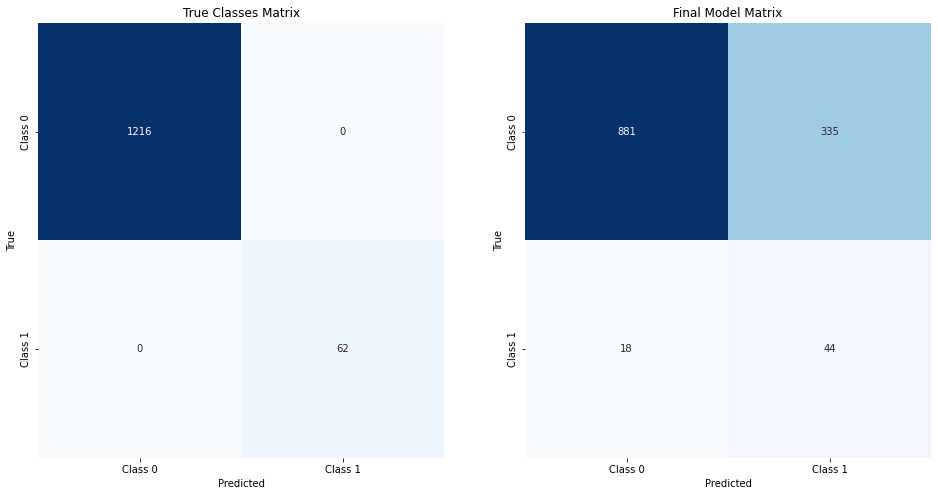

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

sns.heatmap(holdout_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'],
            ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
ax[1].set_title('Final Model Matrix')

sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'],
            ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title('True Classes Matrix')
plt.show()

In [169]:
best_model.named_steps

{'resampling': SMOTE(random_state=1),
 'model': RandomForestClassifier(max_depth=6, min_samples_split=10, random_state=1)}

In [46]:
# Retrieve the Random Forest model from the pipeline
random_forest_model = best_model.named_steps['model']

# Access the feature importances
feature_importances = random_forest_model.feature_importances_
feature_importances

array([4.47983278e-01, 4.61077084e-02, 4.45339243e-02, 8.28670279e-02,
       9.12939100e-02, 5.72472868e-03, 5.49011185e-03, 2.16128035e-02,
       2.41421993e-02, 3.33932553e-02, 4.06250243e-02, 5.04534479e-03,
       7.48174871e-03, 2.06976285e-02, 1.10656451e-02, 5.64579643e-03,
       6.72007721e-03, 4.68804605e-02, 1.26437076e-02, 1.25051993e-07,
       1.60759319e-02, 2.39695624e-02])

In [183]:
importances = pd.DataFrame(feature_importances, columns=['feature importance'])

In [184]:
features = pd.DataFrame(X_trainval.columns, columns=['feature names'])

In [188]:
feature_importances = pd.concat([features,importances], axis=1)
feature_importances.sort_values('feature importance', ascending=False)

,feature names,feature importance
0,age,4.479833e-01
4,ever_married=yes,9.129391e-02
3,ever_married=no,8.286703e-02
17,work_type=children,4.688046e-02
1,avg_glucose_level_log,4.610771e-02
2,bmi,4.453392e-02
10,hypertension=yes,4.062502e-02
9,hypertension=no,3.339326e-02
8,heart_disease=yes,2.414220e-02
21,work_type=self_employed,2.396956e-02


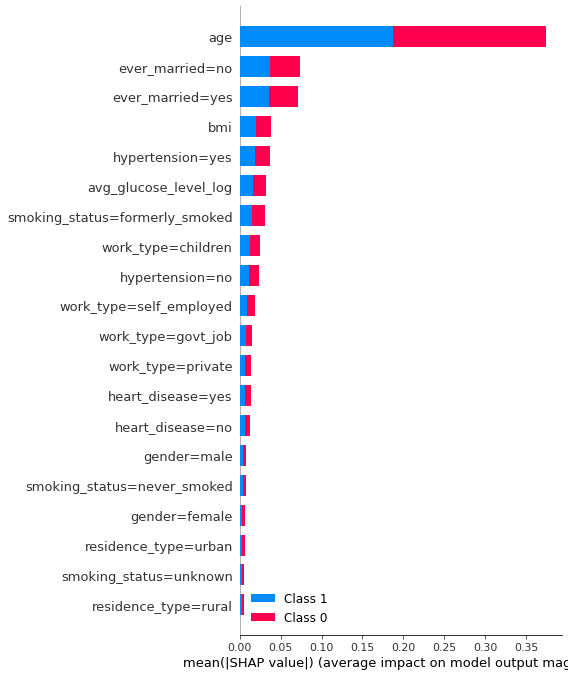

In [48]:
model = best_model
explainer = shap.TreeExplainer(model.named_steps['model'])
expected_values = explainer.expected_value
shap_values = explainer.shap_values(X_holdout)
shap.summary_plot(shap_values, X_holdout.columns, plot_type='bar')